In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#將壓縮檔複製到/content
! cp  "/content/drive/My Drive/flower/training.zip" /content/

In [3]:
#解壓縮訓練集
! unzip /content/training -d /content/training/ > data_unzip.log

In [4]:
import shutil
shutil.move("/content/training/label.csv", "/content")

'/content/label.csv'

In [5]:
#read csv
import pandas as pd
flower_data = pd.read_csv('/content/label.csv')

In [6]:
! python --version

Python 3.7.13


In [7]:
label = []
for i in range(219):
  #請輸入程式碼
  temp = flower_data[flower_data['category'] == i]
  label.append(temp.reset_index())
  #print('第' + str(i) + '類張數: ' + str(len(label[i])))
label[0]

,index,filename,category
0,0,me3uqlixjn.jpg,0
1,1,5c0vsrdtpq.jpg,0
2,2,swixut5b3l.jpg,0
3,3,m0eqa926lo.jpg,0
4,4,5jr6x2y9p8.jpg,0
5,5,9y7sv8xqc2.jpg,0
6,6,nzt9hr5se2.jpg,0
7,7,niky1zwp74.jpg,0
8,8,3jdlrqgcz4.jpg,0
9,9,m4dtjfyu0w.jpg,0


In [8]:
###生成很多照片###
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import shutil
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import pandas as pd
%matplotlib inline

In [9]:
def ImageRotate(img, indx):
    height, width = img.shape[:2]
    center = (width / 2, height / 2)
    angle_list = [90, -90]
    angle = angle_list[indx]
    scale = 1
    M = cv2.getRotationMatrix2D(center, angle, scale)
    image_rotation = cv2.warpAffine(src=img, M=M, dsize=(height, width))
    return image_rotation


In [11]:
from PIL import Image
from PIL import ImageEnhance
import imutils
import cv2
import numpy 


train_images = []
train_label = []
test_images = []
test_label = []

for i in range(219):
    images_temp = []
    label_temp = [i] * 5
    for j in range(5):
        img = cv2.imread('/content/training/'+label[i]['filename'][j])
        images_temp.append(cv2.resize(img,(160,160), cv2.INTER_AREA))
    test_images += images_temp
    test_label += label_temp


    images_temp = []
    label_temp = [i] * 50
    for k in range(5):
        img = Image.open('/content/training/'+label[i]['filename'][k])
        # 對比
        img_en = ImageEnhance.Contrast(img)
        contrast = 1.5
        img_contrast = img_en.enhance(1.5)
        # PIL 轉 OpenCV
        img_resize = cv2.cvtColor(np.asarray(img_contrast), cv2.COLOR_RGB2BGR)
        img_resize = cv2.resize(img_resize,(160,160), cv2.INTER_AREA)
        # 對比*5
        images_temp.append(img_resize)
        # 水平、垂直、水平+垂直 3*5->15
        images_temp.append(cv2.flip(img_resize, 1))
        images_temp.append(cv2.flip(img_resize, 0))
        images_temp.append(cv2.flip(img_resize, -1))
        # 旋轉2角度 2*5->10
        img_rotation = ImageRotate(img_resize, 0)
        images_temp.append(img_rotation)
        img_rotation = ImageRotate(img_resize, 1)
        images_temp.append(img_rotation)
        # 翻轉(水平、垂直)&旋轉2角度 4*5->20
        img_rotation = ImageRotate(img_resize, 0)
        images_temp.append(cv2.flip(img_rotation, 1))
        images_temp.append(cv2.flip(img_rotation, 0))

        img_rotation = ImageRotate(img_resize, 0)
        images_temp.append(cv2.flip(img_rotation, 1))
        images_temp.append(cv2.flip(img_rotation, 0))
    train_images += images_temp
    train_label += label_temp
print(len(test_images))
print(len(train_images))

1095
10950


In [ ]:
flower_data

,filename,category
0,me3uqlixjn.jpg,0
1,5c0vsrdtpq.jpg,0
2,swixut5b3l.jpg,0
3,m0eqa926lo.jpg,0
4,5jr6x2y9p8.jpg,0
...,...,...
2185,9a4ryif2xc.jpg,218
2186,nhs2oz6q7g.jpg,218
2187,atvix0fwnq.jpg,218
2188,wpd8temlgf.jpg,218


In [ ]:
type(flower_data['category'])
flower_data['category'] = flower_data['category'].astype(str)#t_col需轉乘str!!否則會出錯 

In [12]:
#將 list 轉成 array
import numpy as np
from sklearn.utils import shuffle
x_train = np.array(train_images)
x_test = np.array(test_images)
y_train = np.array(train_label)
y_test = np.array(test_label)

In [13]:
#將訓練集進行shuffle
import random
#請輸入程式碼
x_train, y_train = shuffle(x_train, y_train, random_state = random.seed())

In [14]:
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

x_train shape:  (10950, 160, 160, 3)
x_test shape:  (1095, 160, 160, 3)


In [15]:
print('y_train shape:',y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (10950,)
y_test shape: (1095,)


In [16]:
print(y_train[0:10])

[ 31 145 142  26 179 129  58  86  98  15]


In [17]:
x_train_norm = x_train.astype('float32')/255
x_test_norm = x_test.astype('float32')/255

In [18]:
print(x_train_norm[0][0][0])

[0.33333334 0.3882353  0.30980393]


In [19]:
from tensorflow.keras import utils

# 轉換前
print(y_train[0])

31


In [20]:
# 進行 One-hot 編碼轉換...
y_train_onehot = utils.to_categorical(y_train, 219)
y_test_onehot = utils.to_categorical(y_test, 219)
# 轉換後
print(y_train_onehot[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


In [23]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

import tensorflow.keras.applications as tensorflow_model
import numpy as np
from tensorflow.keras.optimizers import Adam
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3
import os
import tensorflow as tf
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

# 設定模型儲存條件
checkpoint = ModelCheckpoint('InceptionResNetV2_checkpoint_v2.h5', verbose=1,
                          monitor='val_loss', save_best_only=True,
                          mode='min')

# 設定lr降低條件(0.001 → 0.0005 → 0.00025 → 0.000125 → 0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                           patience=5, mode='min', verbose=1,
                           min_lr=1e-5)

In [24]:
conv_base = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(160, 160, 3))
conv_base.trainable = True

87924736/87910968 [==============================] - 1s 0us/step


In [25]:
#凍結前面的層，訓練後20層
for layers in conv_base.layers[:-20]:
    layers.trainable = False

In [26]:
#建構模型
model = tf.keras.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.GlobalAveragePooling2D())#加入全局平均池化層
model.add(tf.keras.layers.Dense(219, activation='softmax'))#輸出層
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 219)               448731    
                                                                 
Total params: 22,251,515
Trainable params: 2,384,091
Non-trainable params: 19,867,424
_________________________________________________________________


In [27]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
history = model.fit(x=x_train_norm,y=y_train_onehot,batch_size=32,callbacks=[estop,checkpoint,reduce_lr],epochs=20,validation_split=0.1)

Epoch 1/20
308/308 [==============================] - ETA: 0s - loss: 1.7391 - accuracy: 0.6474
Epoch 00001: val_loss improved from inf to 0.52212, saving model to InceptionResNetV2_checkpoint_v2.h5
308/308 [==============================] - 534s 2s/step - loss: 1.7391 - accuracy: 0.6474 - val_loss: 0.5221 - val_accuracy: 0.8639 - lr: 0.0010
Epoch 2/20
308/308 [==============================] - ETA: 0s - loss: 0.1038 - accuracy: 0.9906
Epoch 00002: val_loss improved from 0.52212 to 0.22327, saving model to InceptionResNetV2_checkpoint_v2.h5
308/308 [==============================] - 518s 2s/step - loss: 0.1038 - accuracy: 0.9906 - val_loss: 0.2233 - val_accuracy: 0.9516 - lr: 0.0010
Epoch 3/20
308/308 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.9996
Epoch 00003: val_loss improved from 0.22327 to 0.12346, saving model to InceptionResNetV2_checkpoint_v2.h5
308/308 [==============================] - 518s 2s/step - loss: 0.0227 - accuracy: 0.9996 - val_loss: 0.1

In [29]:
import matplotlib.pyplot as plt
#建置繪圖函式
def show_train_history(train_history,train,validation,label):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(label)
    plt.xlabel('Epoch')
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

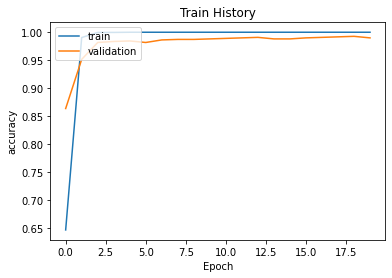

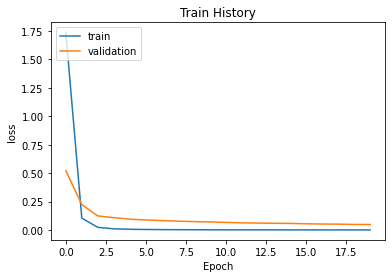

In [30]:
#顯示訓練結果
show_train_history(history,'accuracy','val_accuracy','accuracy')
show_train_history(history,'loss','val_loss','loss')

In [31]:
# evaluate
test_loss,test_val = model.evaluate(x_test_norm,y_test_onehot)
print('測試資料損失值:', test_loss)
print('測試資料準確度:', test_val)

35/35 [==============================] - 50s 1s/step - loss: 0.0116 - accuracy: 0.9973
測試資料損失值: 0.011586254462599754
測試資料準確度: 0.9972602725028992


In [32]:
from keras.models import load_model
model.save('/content/drive/My Drive/flower/flower_0611_InceptionV3epoch20_numtraindata50.h5') 